In [1]:
import sys
# for local development
RT_LIBS_PATH = "/Users/alex/Dev_projects/MyOwnRepo/rt_libs/src"
BA_LIBS_PATH = "/Users/alex/Dev_projects/MyOwnRepo/basic_application/src"
sys.path.append(RT_LIBS_PATH)
sys.path.append(BA_LIBS_PATH)

In [2]:
%matplotlib notebook
db_connect_params = {
    "host" : "194.87.210.189",
    "port" : 59000,
    "user" : "alex",
    "password" : "Xrxcmr758",
    "database" : "rt5"
}

In [3]:
import time
import cProfile, pstats
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [4]:
from data_providers import DbDataProviderRT5
from data_providers import ClickHouseConnector

from core.context import BasicContext
from data_point import DataPoint, DataPointFactory
from core_v3.action_controller import ActionControllerDiffReward

from core.observation_builder.precompute import PrecomputeOrderbookDiffFeature

from core.observation_builder.features2 import ProfitFeature2D

ModuleNotFoundError: No module named 'core'

## DatasetDownload

In [5]:
path_train = "/Users/alex/Dev_projects/RT/model_train/datasets/rt5/03.BTC_USDT-300-train.csv"
path_test = "/Users/alex/Dev_projects/RT/model_train/datasets/rt5/03.BTC_USDT-300-test.csv"
path_test2 = "/Users/alex/Dev_projects/RT/model_train/datasets/rt5/03.BTC_USDT-300-test2.csv"

data_train = pd.read_csv(path_train, index_col='ts')
data_test = pd.read_csv(path_test, index_col='ts')
data_test2 = pd.read_csv(path_test2, index_col='ts')

In [6]:
try:
    dataset = pd.read_csv("./test_dataset.csv", index_col='ts')
    print("Прочитано из файла")
except FileNotFoundError:
    
    ts = int(time.time())
    period = 60
    total_points = 5000

    pair = "BTC_USDT"


    #----
    with ClickHouseConnector(db_connect_params) as conn:
        data_provider = DbDataProviderRT5(conn)

        dataset = data_provider.get(
                                ts,
                                period,
                                total_points,
                                pair
                            )
    dataset.to_csv("./test_dataset.csv")
    print("Загружен новый датасет")
    
print(dataset.shape)

Прочитано из файла
(5000, 11)


In [7]:
dataset

,dt,lowest_ask,highest_bid,asks,bids,buy_vol,sell_vol,total_vol,buy_num,sell_num,total_num
ts,,,,,,,,,,,
1675190531,2023-01-31 21:42:11,23150.770,23134.951,"{'23150.77': 1.082469, '23150.78': 0.092513, '...","{'23134.95': 0.14, '23134.94': 0.033976, '2313...",0.016218,0.018967,0.035185,2,2,4
1675190591,2023-01-31 21:43:11,23136.010,23131.549,"{'23136.01': 1.082488, '23136.02': 0.050858, '...","{'23131.55': 0.033981, '23131.54': 0.43231, '2...",0.012107,0.029802,0.041909,4,5,9
1675190651,2023-01-31 21:44:11,23142.900,23138.930,"{'23142.90': 1.082488, '23142.91': 0.002142, '...","{'23138.93': 0.03397, '23138.92': 0.032715, '2...",0.025996,0.007660,0.033656,7,3,10
1675190711,2023-01-31 21:45:11,23138.960,23138.930,"{'23138.96': 1.082488, '23138.97': 0.027, '231...","{'23138.93': 0.03397, '23138.92': 0.032715, '2...",0.025015,0.047751,0.072766,6,8,14
1675190771,2023-01-31 21:46:11,23154.030,23149.602,"{'23154.03': 0.092126, '23160.37': 0.002124, '...","{'23149.60': 0.14, '23149.59': 0.002101, '2314...",0.017419,0.017783,0.035202,4,3,7
...,...,...,...,...,...,...,...,...,...,...,...
1675490231,2023-02-04 08:57:11,23305.970,23305.010,"{'23305.97': 0.001243, '23306.00': 0.000711, '...","{'23305.01': 0.240275, '23305.00': 0.14, '2330...",0.032404,0.012102,0.044506,10,7,17
1675490291,2023-02-04 08:58:11,23315.309,23311.700,"{'23315.31': 0.748515, '23315.32': 0.000363, '...","{'23311.70': 0.240569, '23311.69': 0.068322, '...",0.015981,0.032724,0.048705,10,10,20
1675490351,2023-02-04 08:59:11,23318.760,23311.740,"{'23318.76': 0.748513, '23318.77': 0.001243, '...","{'23311.74': 0.240571, '23311.73': 0.092965, '...",0.041824,0.024563,0.066387,9,5,14


In [8]:
dataset = data_train

# Context

In [9]:
dpf = DataPointFactory(dataset, step_size=1, offset=50, observation_len=10, future_points=0)

context = BasicContext()
action_controller = ActionControllerDiffReward(context)
dp = dpf.get_current_step()
context.update_datapoint(dp)

# Класс фичи

In [10]:
"""
Module with basic features - deal status, rate, profit.
"""

import logging
import numpy as np
import pandas as pd

from core.observation_builder.features2.abstract_feature import AbstractFeature

logger = logging.getLogger(__name__)


class ProfitFeature2D(AbstractFeature):
    """Profit calculation"""
    def __init__(self, context, step_factor=(1,), scale_output=30):
        super().__init__(context, step_factor=step_factor, scale_output=scale_output)

    def _get(self):
        trade_state = self.context.get("is_open", domain="Trade")
        data_point = self.context.data_point
        trade = self.context.trade
        obs = []
        for sf in self.step_factor:
            if trade_state:
                timestamps = data_point.get_points(step_factor=sf)
                mask = (timestamps > trade.open_ts) & (timestamps <= trade.close_ts)
                current_rates = data_point.get_values("highest_bid", step_factor=sf)
                current_rates = current_rates[sf - 1::sf]
                profit = current_rates / trade.open_price - 1 - trade.market_fee
                profit = profit * mask * self.scale_output
            else:
                profit = np.zeros(data_point.observation_len)

            obs.append(profit.reshape(-1, 1))

        feature = np.concatenate([*obs], axis=1)
        return feature
            

In [11]:
"""
Module with basic features - deal status, rate, profit.
"""

import logging
import numpy as np
import pandas as pd

from core.observation_builder.features2.abstract_feature import AbstractFeature

logger = logging.getLogger(__name__)


class ProfitDiffFeature2D(AbstractFeature):
    """Profit calculation"""

    def __init__(self, context, step_factor=(1,), scale_output=100):
        super().__init__(context, step_factor=step_factor, scale_output=scale_output)

    def _get(self):
        trade_state = self.context.get("is_open", domain="Trade")
        data_point = self.context.data_point
        trade = self.context.trade
        obs = []
        for sf in self.step_factor:
            if trade_state:
                timestamps = data_point.get_points(step_factor=sf, num=data_point.observation_len + 1)
                mask = (timestamps > trade.open_ts) & (timestamps <= trade.close_ts)
                current_rates = data_point.get_values("highest_bid", step_factor=sf, num=data_point.observation_len + 1)
                current_rates = current_rates[sf - 1::sf]
                profit = current_rates / trade.open_price - 1 - trade.market_fee
                profit = profit * mask

                profit_diff = np.diff(profit) * self.scale_output

            else:
                profit_diff = np.zeros(data_point.observation_len)

            obs.append(profit_diff.reshape(-1, 1))

        feature = np.concatenate([*obs], axis=1)
        return feature

In [12]:
import numpy as np
d = np.array([1,2,3,2,5, 6])

np.diff(d).shape

(5,)

# Perfomance test

In [13]:
def perfomance_test(dataset):
    dpf = DataPointFactory(dataset, step_size=1, offset=150, observation_len=20, future_points=0)
    dp = dpf.reset()
    done = False
    scale_factor = (1,3)
    
    feature = ProfitFeature2D(context, step_factor=scale_factor, scale_output=1)
    action_controller.apply_action(1)

    while not done:
        dp, done = dpf.get_next_step()
        obs = feature.get()
        
#cProfile.run("perfomance_test(dataset)")

In [14]:
profiler = cProfile.Profile()
profiler.enable()

perfomance_test(dataset)

profiler.disable()

/Users/alex/Dev_projects/MyOwnRepo/rt_libs/src/core/actions/trade_action.py:41: RuntimeWarning: divide by zero encountered in double_scalars
  profit = round(highest_bid / self.open_price - 1 - self.market_fee, 5)
/Users/alex/Dev_projects/MyOwnRepo/rt_libs/src/core/action_controller/trade_controller.py:81: RuntimeWarning: invalid value encountered in double_scalars
  reward = -profit * self.scale_open


In [15]:
stats = pstats.Stats(profiler).sort_stats('tottime')
stats.print_stats()

         626609 function calls (623593 primitive calls) in 1.045 seconds

   Ordered by: internal time

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
     1505    0.162    0.000    0.617    0.000 /var/folders/sk/hq18v07n541fcm73_jz_p_k00000gn/T/ipykernel_2449/3023448369.py:19(_get)
     4517    0.047    0.000    0.244    0.000 /Users/alex/Dev_projects/venvs/env_rt_p39/lib/python3.9/site-packages/pandas/core/indexing.py:834(_getitem_lowerdim)
   123469    0.047    0.000    0.058    0.000 {built-in method builtins.isinstance}
     4517    0.035    0.000    0.664    0.000 /Users/alex/Dev_projects/venvs/env_rt_p39/lib/python3.9/site-packages/pandas/core/indexing.py:954(__getitem__)
     1507    0.034    0.000    0.049    0.000 {method 'get_slice' of 'pandas._libs.internals.BlockManager' objects}
     3010    0.026    0.000    0.054    0.000 /Users/alex/Dev_projects/venvs/env_rt_p39/lib/python3.9/site-packages/pandas/core/frame.py:3463(__getitem__)
    18068    0.0

# Оценка распределения

In [28]:
dataset = data_test

done = False

dpf = DataPointFactory(dataset, step_size=1, offset=460, observation_len=20, future_points=0)
context = BasicContext()
step_factor = (1,3,5)
feature = ProfitFeature2D(context, step_factor=step_factor, scale_output=30)

dp = dpf.get_current_step()
context.update_datapoint(dp)
    
action_controller = ActionControllerDiffReward(context)

results = {}
num = 200
i = 0


while not done:
    dp, done = dpf.get_next_step()
    context.update_datapoint(dp)
    
    
    trade_is_open = context.get("is_open", domain="Trade")
    if i % num ==0:
        if trade_is_open:
            action_controller.apply_action(3)
        else:
            action_controller.apply_action(1)
    
    
    if trade_is_open:
        obs = feature.get()

        for sf_id in range(len(step_factor)):
            values = obs[:, sf_id]

            key_sf = f"sf-{step_factor[sf_id]}"
            if key_sf not in results:
                results[key_sf] = values
            else:
                results[key_sf] = np.concatenate([results[key_sf], values])
            
    i = i + 1
        

<IPython.core.display.Javascript object>


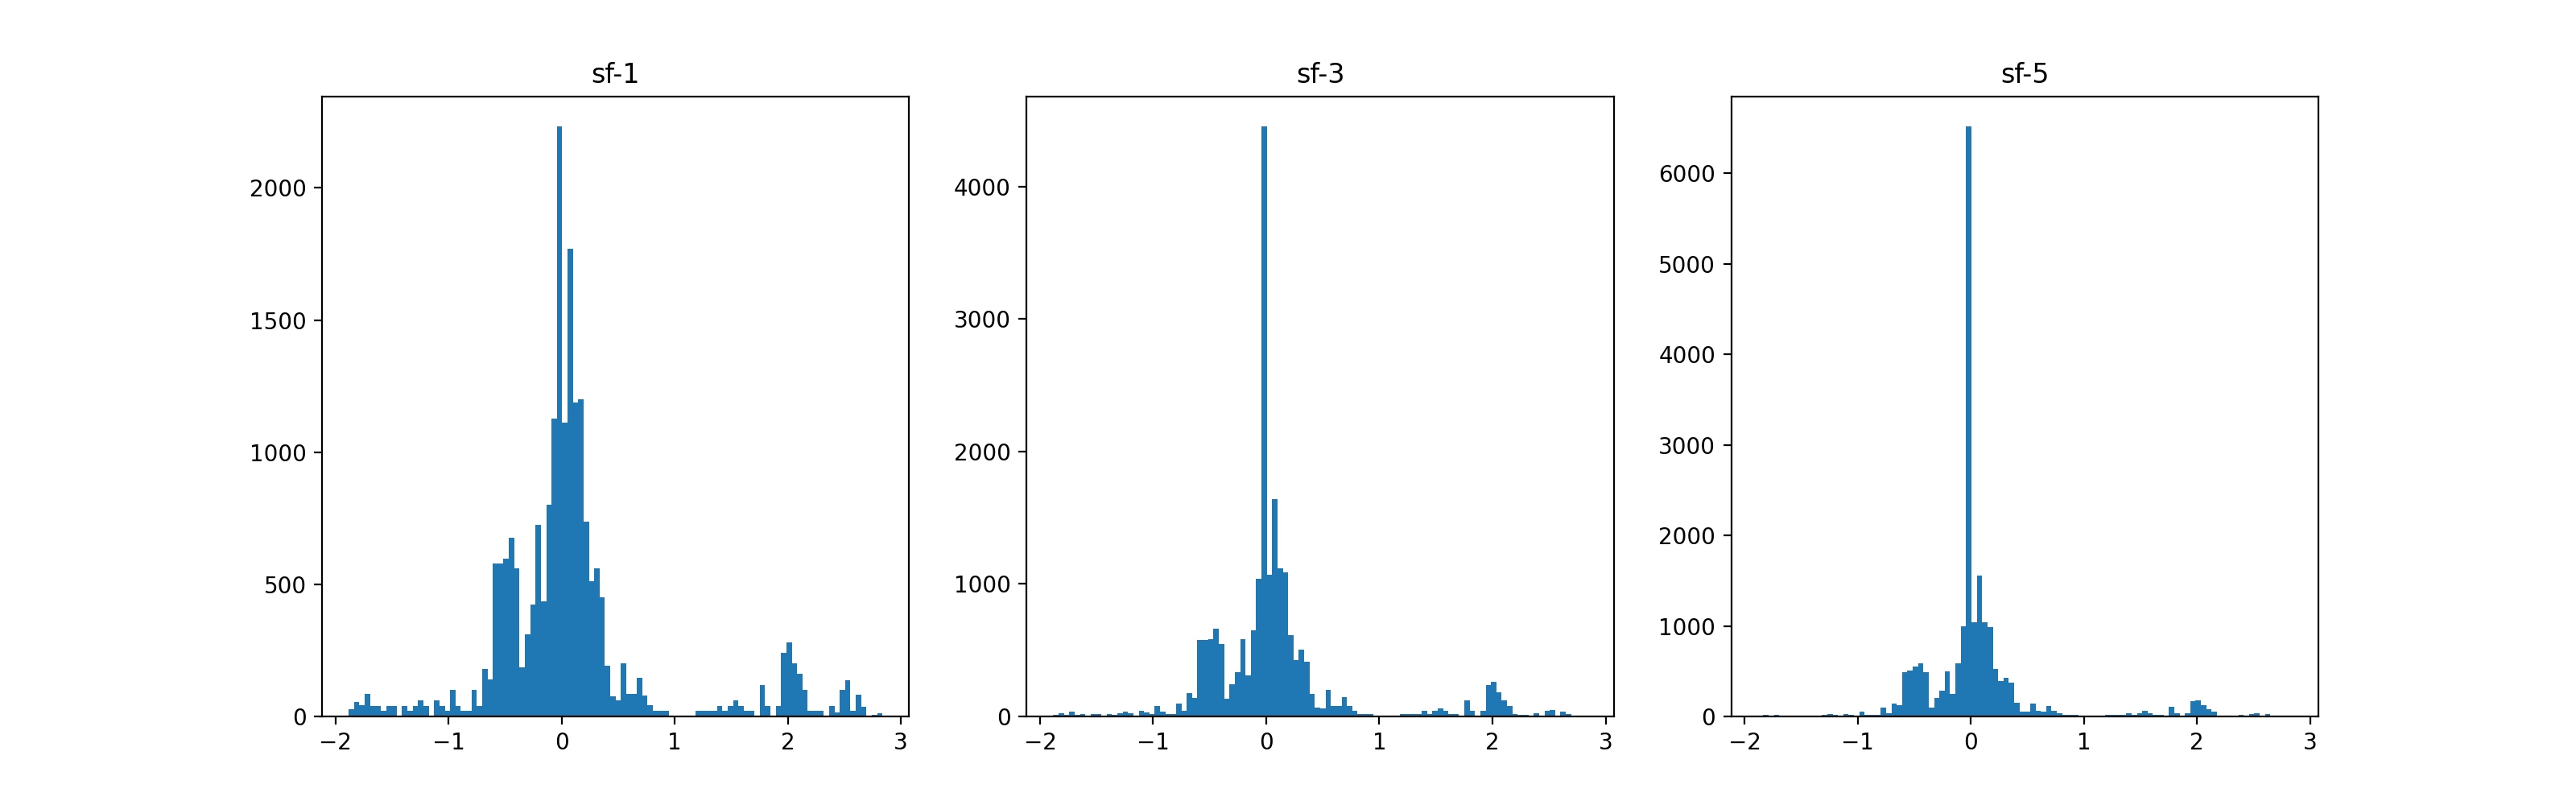

In [29]:
fig, ax = plt.subplots(figsize=(16,5), ncols=len(step_factor), nrows=1)

for sf_id in range(len(step_factor)):
    key_sf = f"sf-{step_factor[sf_id]}"
    values = results[key_sf]
    ax[sf_id].hist(values, bins=100)
    ax[sf_id].title.set_text(key_sf)

In [11]:
feature = ProfitFeature2D(context, step_factor=(1,2,3))

In [43]:
obs = feature.get()
obs

array([[-0.00126779, -0.01837254, -0.0223732 ],
       [-0.00129819, -0.01087517, -0.02477864],
       [-0.00110984, -0.00127643, -0.01257718],
       [-0.0011307 , -0.00120401, -0.00128369],
       [ 0.        , -0.00056535, -0.00074685]], dtype=float32)

In [44]:
current_rate = dp.get_value("highest_bid").values[0]
current_rate

23421.07

## sf=1

In [45]:
dp.data.loc[1675453069:1675453309, "highest_bid"]/current_rate - 1

ts
1675453069   -0.000127
1675453129   -0.000130
1675453189   -0.000111
1675453249   -0.000113
1675453309    0.000000
Name: highest_bid, dtype: float32

## sf=2

In [46]:
obs = feature.get()
obs

array([[-0.00126779, -0.01837254, -0.0223732 ],
       [-0.00129819, -0.01087517, -0.02477864],
       [-0.00110984, -0.00127643, -0.01257718],
       [-0.0011307 , -0.00120401, -0.00128369],
       [ 0.        , -0.00056535, -0.00074685]], dtype=float32)

In [29]:
dp.data.tail(10)

,dt,lowest_ask,highest_bid,asks,bids,buy_vol,sell_vol,total_vol,buy_num,sell_num,total_num
ts,,,,,,,,,,,
1675452769,2023-02-03 22:32:49,23373.021484,23372.439453,"{'23373.02': 0.00035, '23378.43': 0.000379, '2...","{'23372.44': 0.702901, '23372.43': 0.14, '2337...",0.023718,0.028416,0.052134,7,6,13
1675452829,2023-02-03 22:33:49,23396.960938,23383.640625,"{'23396.96': 0.355256, '23396.97': 0.002065, '...","{'23383.64': 0.674272, '23383.63': 0.001246, '...",0.015210,0.016324,0.031534,3,7,10
1675452889,2023-02-03 22:34:49,23409.289062,23399.189453,"{'23409.29': 0.373047, '23409.30': 0.002066, '...","{'23399.19': 0.14, '23399.18': 0.104425, '2339...",0.013877,0.021983,0.035860,3,4,7
1675452949,2023-02-03 22:35:49,23404.089844,23392.009766,"{'23404.09': 0.35958, '23404.10': 0.002056, '2...","{'23392.01': 0.669712, '23392.00': 0.14, '2339...",0.008706,0.019148,0.027854,3,3,6
1675453009,2023-02-03 22:36:49,23424.550781,23418.060547,"{'23424.55': 0.359278, '23424.56': 0.002097, '...","{'23418.06': 0.66927, '23418.05': 0.059953, '2...",0.036118,0.002416,0.038534,3,2,5
1675453069,2023-02-03 22:37:49,23424.910156,23418.101562,"{'23424.91': 0.359278, '23424.92': 0.002107, '...","{'23418.10': 0.669269, '23418.09': 0.14, '2341...",0.021893,0.000513,0.022406,3,1,4
1675453129,2023-02-03 22:38:49,23430.929688,23418.029297,"{'23430.93': 0.359625, '23430.94': 0.001289, '...","{'23418.03': 0.669271, '23418.02': 0.09179, '2...",0.012593,0.015364,0.027957,2,2,4
1675453189,2023-02-03 22:39:49,23424.380859,23418.470703,"{'23424.38': 0.001333, '23432.74': 0.002122, '...","{'23418.47': 0.815634, '23418.44': 0.14, '2341...",0.044688,0.008411,0.053099,9,4,13
1675453249,2023-02-03 22:40:49,23428.791016,23418.421875,"{'23428.79': 0.354612, '23428.80': 0.001272, '...","{'23418.42': 0.673928, '23418.41': 0.640521, '...",0.017010,0.033221,0.050231,7,8,15


In [41]:
avg = 23419.7459
avg/current_rate-1

-5.6547906749249144e-05

In [40]:
avg = 23418.25
avg/current_rate-1

-0.00012041774617344014